In [1]:
import pandas
import numpy as np
import xarray
import matplotlib.pyplot as plt

# read data set from Nautilus files: list of 98% clear locations / dates

df = pandas.read_parquet('/Users/rachelstumpf/Documents/VIIRS_all_98clear_std.parquet')

In [2]:
# read data set from collated night + day, 2016-02-06

data_xr = xarray.open_dataset("/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2016/037/20160206120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc")

In [3]:
# using Nautilus list, find matching date and see what location we should try and extract
# idea is to extract a region we know should have little impact of cloud cover

df['datetime'] = pandas.to_datetime(df['datetime'])

target_date = pandas.to_datetime('2016-02-06')
target_time = pandas.to_datetime('12:00:00')

filtered_df = df[(df['datetime'].dt.date == target_date.date()) & (df['datetime'].dt.time == target_time.time())]

# okay, now we have a matching time and can extract from the xarray data set.
# let's work with the row: latitude -25.600262, longitude 12.210180

# filtered_df.iloc[-1]

In [4]:
# find the region of interest in the collated data set

lat_min = -50
lat_max = 0
lon_min = -12.5
lon_max = 37.5

section = data_xr.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))

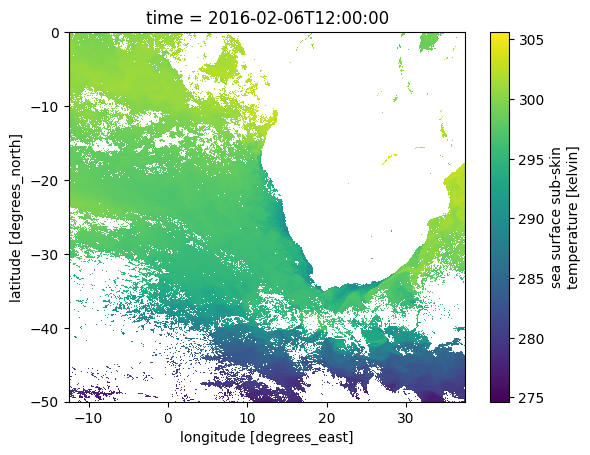

In [5]:
# plot this section, look for the exact point to the left of land mass

ds = xarray.Dataset(section)
ds['sea_surface_temperature'].plot()
plt.show()

In [6]:
# filter data set to not include polar regions

lat_min = -57
lat_max = 57

data_xr2 = data_xr.sel(lat=slice(lat_max, lat_min))
variable = data_xr2['sea_surface_temperature']

In [7]:
# create subarray from variable filtered data, need less than 2% masked pixels

subarray_size = 64
max_nan_pixels = subarray_size ** 2 * 0.02 # we can have a max of 81 masked pixels
print(max_nan_pixels)

nan_mask = np.isnan(data_xr['sea_surface_temperature'])

# nan_mask.mean()
# (nan_mask == False).sum()
# In this entire region, we can see that land values take on "nan" for sst

81.92


In [8]:
# extract region surrounding target area (since we know it should have less than 2% masked)

centered_lat = -25.6
centered_lon = 12.21
pixel_num = 64

lats = variable['lat'].values
lons = variable['lon'].values

center_lat = np.abs(lats-centered_lat).argmin()
center_lon = np.abs(lons-centered_lon).argmin()

start_lat = center_lat - (pixel_num // 2)
end_lat = start_lat + pixel_num
start_lon = center_lon - (pixel_num // 2)
end_lon = start_lon + pixel_num

subarray = variable.isel(lat = slice(start_lat,end_lat), lon = slice(start_lon,end_lon))

In [9]:
# now check the masking percentage in this subarray

# np.isnan(subarray).mean() # perfect, only 0.00121438!

# np.isnan(subarray).sum()

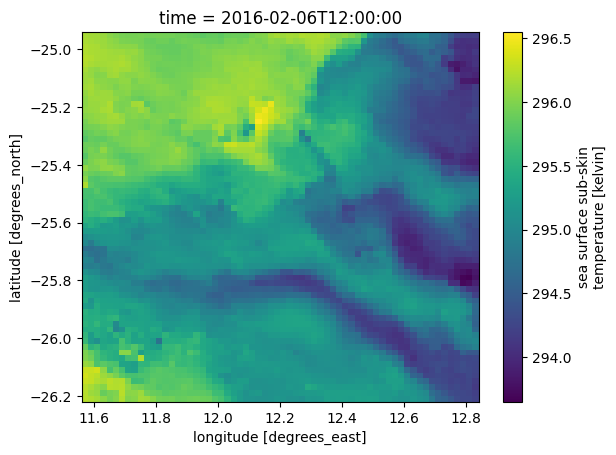

In [10]:
# plot this region

subarray.plot()
plt.show()

In [11]:
# across this grid, what is the average sea surface temperature? 

print(subarray.mean())
# the mean temperature is 295.19714, should I be converting this to Celsius? 
# in the Nautilus data set, the temperature for this region should be 22.454, which is 295.604 Kelvin
# I don't know if this subarray is the right pixel dimensions
# so what we want from this is a region that is 64 pixels latitude by 64 pixels longitude, centered on the point chosen
# might need to cut out something bigger and then reduce down to 64x64

<xarray.DataArray 'sea_surface_temperature' ()>
array(295.19714, dtype=float32)


In [13]:
# we want a point centered on lon,lat = 70W,35N on 2020-03-11
# this means we need lon = -70, lat = 35

data_xr2 = xarray.open_dataset("/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2020/071/20200311120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc")
data_xr2

centered_lat = 35
centered_lon = -70
pixel_num = 64

lats = data_xr2['lat'].values
lons = data_xr2['lon'].values

center_lat = np.abs(lats-centered_lat).argmin()
center_lon = np.abs(lons-centered_lon).argmin()

start_lat = center_lat - (pixel_num // 2)
end_lat = start_lat + pixel_num
start_lon = center_lon - (pixel_num // 2)
end_lon = start_lon + pixel_num

subset = data_xr2.isel(lat = slice(start_lat,end_lat), lon = slice(start_lon,end_lon))

In [14]:
np.count_nonzero(np.isnan(subset['sea_surface_temperature'].values))
np.isnan(subset['sea_surface_temperature']).mean()

# there are 4096 pixels, and 3230 in this subset are nan

<xarray.DataArray 'sea_surface_temperature' ()>
array(0.78857422)

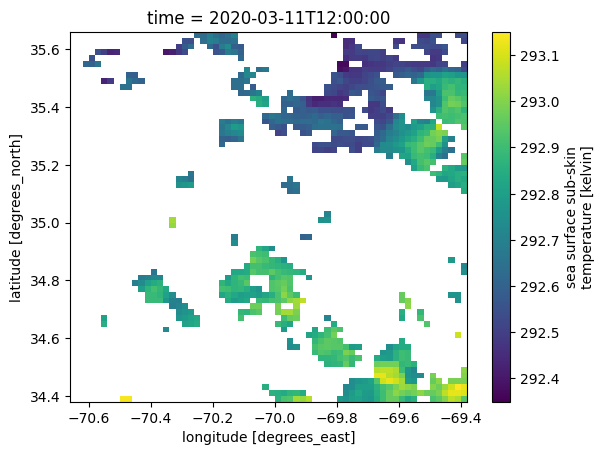

In [15]:
subset['sea_surface_temperature'].plot()
plt.show()

In [17]:
# using subarray again, try to use plotting technique "show_image"

from ulmo.plotting import plotting
plotting.show_image[subarray]

ModuleNotFoundError: No module named 'ulmo'